In [231]:
# imports
from bs4 import BeautifulSoup
from datetime import date
from os.path import exists
import requests, shutil, pandas as pd, numpy as np

In [232]:
# url, request and response
url = 'https://store.steampowered.com/hwsurvey/videocard/'
response = requests.get(url)

In [233]:
soup = BeautifulSoup(response.content)


In [234]:
data = soup.findAll('div', id='sub_stats')[0]

In [235]:
#print(data)

In [236]:
# extracting recent 5 months
data1 = data.findAll('div', class_='col_header')[1:6]
months = []
for month in range(len(data1)):
    months.append(data1[month].text)

In [237]:
# data extraction line for gpus
data2 = data.findAll('div', class_='substats_col_left')[8:109]

In [238]:
# data extraction lines for Recent month column %
data3 = data.findAll('div', class_='substats_col_month_last_pct')[8:109]

In [239]:
# data extraction for other months
data4 = data.findAll('div', class_='substats_col_month')[32:]

In [240]:
# creating months-percent dict
numerate = 0
months_percent = {
    months[0] : [], 
    months[1] : [],
    months[2] : [],
    months[3] : [],
    months[4] : []
}

# ex: data4 = [num for month a, num for month b, num for month c, num for month d, num for month a ...]

for percent in data4:

    if (str(months[0]) in percent.text):
        break
    months_percent[months[numerate]].append(percent.text[:-1])
    numerate += 1
    if (numerate == 4):
        numerate = 0

for percent in data3:
    months_percent[months[4]].append(percent.text[:-1])

In [241]:
# Getting list of gpus
gpu_percent_dict = {}
num = 0
for entry in data2:
    temp = [
        months_percent[months[0]][num],
        months_percent[months[1]][num],
        months_percent[months[2]][num],
        months_percent[months[3]][num],
        months_percent[months[4]][num]
    ]
    if ( ('NVIDIA' in entry.text) or ('AMD' in entry.text) or ('Intel' in entry.text) ):
        gpu_percent_dict[entry.text.strip()] = temp
    if ( ('Other' in entry.text)):
        gpu_percent_dict['Other'] = temp

    num += 1

In [242]:
#print(gpu_percent_dict)

In [243]:
# create dataframe
df = pd.DataFrame.from_dict(gpu_percent_dict, orient='index', columns=[
    months[0],
    months[1],
    months[2],
    months[3],
    months[4]])

In [244]:
# Dataframe Reorganization
df['GPU'] = df.index
df = df[['GPU',months[0],months[1],months[2],months[3],months[4]]]
df = df.reset_index(drop=True)

In [245]:
# test df methods
len(df)

101

In [246]:
# filling empty column values with no data
df = df.replace(r'^\s*$', np.NaN, regex=True)
df.fillna(0, inplace=True)

In [247]:
# turning all strings into floats
for num in range(0,5):
    df[months[num]] = df[months[num]].apply(lambda x: float(x))

In [248]:
# writing to csv with current month of data collection

file_name = f'steam_gpu_survey-{date.today().month}-{date.today().year}'

# check if file already exists
if (not exists(f"data/{file_name}")):

    # writing csv file
    df.to_csv(path_or_buf=file_name, index=False)

    # moving csv file to data directory
    source = f'{file_name}'
    destination = "data"
    shutil.move(source, destination)
else:
    print("Csv File Already Exists")

Csv File Already Exists


Project Milestone 2

What gpu(s) is the median percentage used in the most recent month? This is done by finding the median value from the most recent month column which is months[4]. then drop the bad row, and then get the max usage.

In [249]:
# copy original dataframe
df_copy = df.copy()
# locate median values
df_copy.loc[df_copy[months[4]] == df_copy[months[4]].median(), ['GPU', months[4]]]

,GPU,NOV
48,Intel HD Graphics 520,0.41
49,NVIDIA GeForce MX250,0.41
50,Intel Haswell,0.41
51,NVIDIA GeForce GT 710,0.41


What percentage is the highest used gpu recently?

In [250]:
# remove 'other' value in dataframe
df_copy.drop(index=100, inplace=True)
# data cleaning
df_copy.drop(columns=['GPU',months[0],months[1], months[2], months[3]], inplace=True)

In [251]:
# get max gpu usage percentage
df_copy[months[4]].max()

7.83

What percentage is the lowest used gpu? using the same dataframe with the max, use min instead.

In [252]:
# get min gpu usage percentage
df_copy[months[4]].min()

0.15

What gpu is gaining the most attraction? drop the bad input named other. create a column called difference equalling the sum of the differences between all the months. Then use min because the smaller the number the number is going up over time. If the number is bigger it is losing attraction.

In [253]:
# creating copy of original dataframe
df_copy2 = df.copy()
# dropping 'other' value in row as its not needed and will mess up result
df_copy2.drop(index=100, inplace=True)

In [254]:
# most recent month subtracting earlier months
df_copy2['Difference'] = (df_copy2[months[0]] - df_copy2[months[1]]) + (df_copy2[months[1]] - df_copy2[months[2]]) + (df_copy2[months[2]] - df_copy2[months[3]]) + (df_copy2[months[3]] - df_copy2[months[4]])

In [255]:
# minimum value means the most used gpu because higher gpu usages 
# subtracted from each other makes the smallest number
df_copy2.loc[ df_copy2['Difference'] == df_copy2['Difference'].min()]

,GPU,JUL,AUG,SEP,OCT,NOV,Difference
19,AMD Radeon Graphics,0.0,0.0,1.01,1.11,1.25,-1.25


What gpu is losing the most attraction? Using the same dataframe for gaining the most attraction, use max instead of min for losing attraction.

In [256]:
# can use the same dataframe instead of min use max as highest number means lowest subtraction
df_copy2.loc[ df_copy2['Difference'] == df_copy2['Difference'].max()]

,GPU,JUL,AUG,SEP,OCT,NOV,Difference
0,NVIDIA GeForce GTX 1060,9.17,10.46,8.64,8.08,7.83,1.34


Graph Section

What generation of GPUs are the most popular?

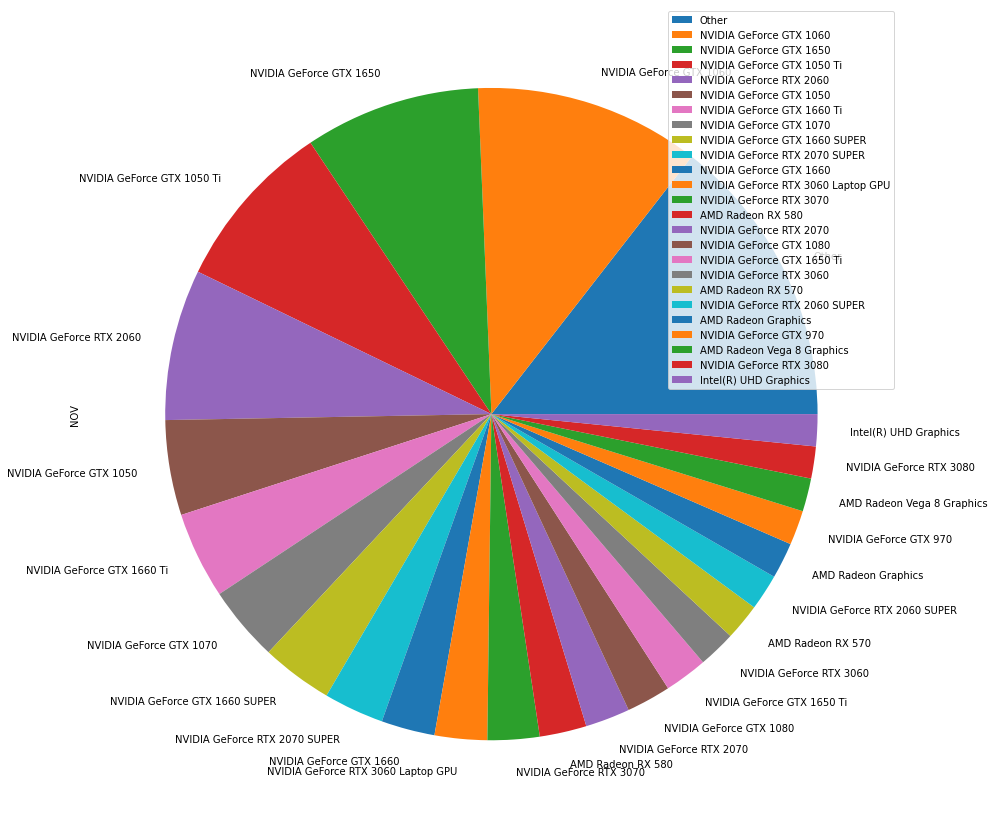

In [257]:
# create copy of original dataframe
df_plot = df.copy()
df_plot.sort_values(by=[months[4]], ascending=False, inplace=True)
# change index to GPUs
df_plot.set_index('GPU', inplace=True)
# plot from dataframe
plot = df_plot.head(25).plot.pie(y=months[4], figsize=(15,15))

As seen from the top 25 selection of GPUs most of them are of the 60s series of each generation as the most popular.

What Gpu is gaining the most attraction?

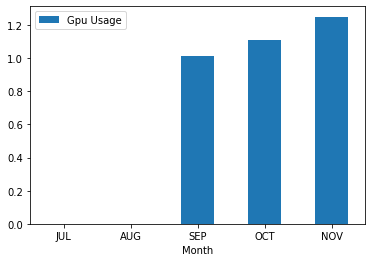

In [258]:
# reusing difference column 
df_plotting = df_copy2.loc[ df_copy2['Difference'] == df_copy2['Difference'].min()]
plot_df = pd.DataFrame({'Month':[months[0],months[1],months[2],months[3],months[4]],'Gpu Usage':[df_plotting[months[0]].values[0], df_plotting[months[1]].values[0], df_plotting[months[2]].values[0], df_plotting[months[3]].values[0], df_plotting[months[4]].values[0]]})
plot2 = plot_df.plot.bar(x='Month', y='Gpu Usage', rot=0)

This bar graph shows the attraction towards that gpu is growing over time and it is growing the most

Map() function

In [259]:
df_apply = df.copy()
df_apply['GPU_GROUP'] = df['GPU'].apply(lambda x: x.split(' ')[0].strip())
df_apply['GPU_GROUP']

0      NVIDIA
1      NVIDIA
2      NVIDIA
3      NVIDIA
4      NVIDIA
        ...  
96        AMD
97     NVIDIA
98     NVIDIA
99      Intel
100     Other
Name: GPU_GROUP, Length: 101, dtype: object

In [260]:
df_apply['GPU_GROUP'].value_counts()

NVIDIA      62
AMD         21
Intel       14
Intel(R)     3
Other        1
Name: GPU_GROUP, dtype: int64

In [261]:
df_1hot = pd.get_dummies(df.GPU, prefix='GPU').copy()
df_1hot

,GPU_AMD Radeon Graphics,GPU_AMD Radeon R5 Graphics,GPU_AMD Radeon R7 Graphics,GPU_AMD Radeon RX 460,GPU_AMD Radeon RX 470,GPU_AMD Radeon RX 480,GPU_AMD Radeon RX 550,GPU_AMD Radeon RX 5500 XT,GPU_AMD Radeon RX 560,GPU_AMD Radeon RX 5600 XT,...,GPU_NVIDIA GeForce RTX 3060,GPU_NVIDIA GeForce RTX 3060 Laptop GPU,GPU_NVIDIA GeForce RTX 3060 Ti,GPU_NVIDIA GeForce RTX 3070,GPU_NVIDIA GeForce RTX 3070 Laptop GPU,GPU_NVIDIA GeForce RTX 3070 Ti,GPU_NVIDIA GeForce RTX 3080,GPU_NVIDIA GeForce RTX 3080 Ti,GPU_NVIDIA GeForce RTX 3090,GPU_Other
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Training

In [262]:
sklearndf = df.copy()
sklearndf.drop(index=100, inplace=True)
sklearndf = sklearndf[[months[0],months[1],months[2],months[3],months[4], 'GPU']]
sklearndf
X = sklearndf.iloc[:, :-1].values
y = sklearndf.iloc[:, 5].values

In [263]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [264]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [265]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.4)

In [266]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

In [267]:
y_pred = classifier.predict(X_test)

In [268]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
                                    precision    recall  f1-score   support

               AMD Radeon Graphics       0.00      0.00      0.00       1.0
            AMD Radeon R5 Graphics       0.00      0.00      0.00       1.0
            AMD Radeon R7 Graphics       0.00      0.00      0.00       1.0
                 AMD Radeon RX 460       0.00      0.00      0.00       0.0
                 AMD Radeon RX 470       0.00      0.00      0.00       0.0
                 AMD Radeon RX 480       0.00      0.00      0.00       0.0
                 AMD Radeon RX 550       0.00      0.00      0.00       1.0
             AMD Radeon RX 5500 XT       0.00      0.00      0.00       1.0
                 AMD Radeon RX 570       0.00      0.00      0.00       0.0
                AMD Radeon RX 5700       0.00      0.00      0.00       0.0
                 AMD Radeon RX 580       0.

C:\Users\KyuTe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KyuTe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KyuTe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 